In [95]:
#Importing necessary libraries
import pandas as pd
import numpy as np

In [96]:
#Loading the dataset 
df = pd.read_parquet('/Users/calvinfrederick/Desktop/university/Case Compeition : Intern etc./Datathon 2024/catB_train.parquet')
print(df)

          clntnum race_desc ctrycode_desc clttype stat_flag min_occ_date  \
19550  91b546e924   Chinese     Singapore       P    ACTIVE   2017-10-31   
4600   896bae548c   Chinese     Singapore       P    ACTIVE   2007-05-23   
13337  f364439ae6    Others     Singapore       P    ACTIVE   2019-08-31   
15074  70f319cfe1   Chinese     Singapore       P    ACTIVE   2021-10-18   
19724  2647a81328   Chinese     Singapore       P    ACTIVE   2018-07-20   
...           ...       ...           ...     ...       ...          ...   
11284  3363260248      None     Singapore       P    LAPSED   2016-08-01   
11964  c3509f0aef   Chinese     Singapore       P    ACTIVE   1990-03-20   
5390   6e44cfb3e7   Chinese     Singapore       P    ACTIVE   2007-12-31   
860    dd4e362f9f    Others     Singapore       P    ACTIVE   2007-09-01   
15795  3788d06ec7    Indian     Singapore       P    ACTIVE   2011-10-24   

       cltdob_fix cltsex_fix  flg_substandard  flg_is_borderline_standard  \
19550  197

In [6]:
#Preliminary Inspection
#First few rows of the dataset
print(df.head())

          clntnum race_desc ctrycode_desc clttype stat_flag min_occ_date  \
19550  91b546e924   Chinese     Singapore       P    ACTIVE   2017-10-31   
4600   896bae548c   Chinese     Singapore       P    ACTIVE   2007-05-23   
13337  f364439ae6    Others     Singapore       P    ACTIVE   2019-08-31   
15074  70f319cfe1   Chinese     Singapore       P    ACTIVE   2021-10-18   
19724  2647a81328   Chinese     Singapore       P    ACTIVE   2018-07-20   

       cltdob_fix cltsex_fix  flg_substandard  flg_is_borderline_standard  \
19550  1974-05-09     Female              0.0                         0.0   
4600   1979-11-11       Male              0.0                         0.0   
13337  1976-01-28       Male              0.0                         0.0   
15074  1976-03-19     Female              0.0                         0.0   
19724  1995-07-31     Female              0.0                         0.0   

       ...  recency_giclaim  giclaim_cnt_success  recency_giclaim_success  \
195

In [7]:
#Summary of the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 17992 entries, 19550 to 15795
Columns: 304 entries, clntnum to f_purchase_lh
dtypes: float64(44), int64(46), object(214)
memory usage: 41.9+ MB
None


In [8]:
#Basic statistical summary of numberical features
print(df.describe())

       flg_substandard  flg_is_borderline_standard  flg_is_revised_term  \
count     16978.000000                16978.000000         16978.000000   
mean          0.040287                    0.033102             0.000707   
std           0.196638                    0.178907             0.026577   
min           0.000000                    0.000000             0.000000   
25%           0.000000                    0.000000             0.000000   
50%           0.000000                    0.000000             0.000000   
75%           0.000000                    0.000000             0.000000   
max           1.000000                    1.000000             1.000000   

       flg_is_rental_flat  flg_has_health_claim  flg_has_life_claim  \
count        16978.000000          16978.000000        16978.000000   
mean             0.012546              0.048769            0.003593   
std              0.111306              0.215391            0.059835   
min              0.000000              0

In [9]:
#Handling missing values
print(df.isnull().sum())

#We can see that race_desc and ctrycode_desc have missing values, what do we want to do with these values?
#Numerical variables (f_purcahse_lh)
##Small dataset, impute missing numerical values with mean, median or a value that makes sense

#Categorical variables (race_desc, ctrycode_desc)
##Use predictive modelling: Train a model to predict the missing categorical values based on other available information.
##Impute with a placeholder category like "Unknown" if predictive modelling is not feasible.

#Variables that do not provide insight for customer journey experience
##flg_gi_claim_29d435_ever and its variants


clntnum                         0
race_desc                    3996
ctrycode_desc                  20
clttype                         0
stat_flag                       0
                            ...  
flg_gi_claim_29d435_ever    17992
flg_gi_claim_058815_ever    17992
flg_gi_claim_42e115_ever    17992
flg_gi_claim_856320_ever    17992
f_purchase_lh               17282
Length: 304, dtype: int64


In [10]:
#Filling the mising values for ctry_code (categorical) using mode
df['ctrycode_desc'].fillna(df['ctrycode_desc'].mode()[0], inplace=True)

In [11]:
#Dropping columns that are irrelevant to the agenda
df.drop(['flg_gi_claim_29d435_ever'], axis=1, inplace=True)
df.drop(['flg_gi_claim_058815_ever'], axis=1, inplace=True)
df.drop(['flg_gi_claim_42e115_ever'], axis=1, inplace=True)
df.drop(['flg_gi_claim_856320_ever'], axis=1, inplace=True)

In [12]:
#Dealing with the race_desc
##We do not consider race a key factor in our analysis, we can consider imputing an 'Unknown' into it
df['race_desc'].fillna('Unknown', inplace=True)

In [13]:
#Removing duplicate rows
df = df.drop_duplicates()

In [97]:
# Convert target col to 0 or 1
df["f_purchase_lh"] = df["f_purchase_lh"].fillna(0)

# Identifiy numeric columns and fill null values with the median value
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
df[numeric_cols] = df[numeric_cols].apply(lambda x: x.fillna(x.median()))

# Drop non-numeric cols
non_numeric_cols = df.select_dtypes(include=["string", "object"]).columns
df = df.drop(columns=non_numeric_cols)

y = df["f_purchase_lh"]
X = df.drop(columns=['f_purchase_lh'])

In [14]:
#Imputing missing values for f_purchase_lh because it is an important factor in our analysis
from sklearn.impute import KNNImputer

# Create a DataFrame containing only the column you want to impute
column_to_impute = 'f_purchase_lh'
df_impute = df[[column_to_impute]].copy()

# Initialize the KNNImputer with the number of neighbors you want to consider
knn_imputer = KNNImputer(n_neighbors=5)  # You can adjust n_neighbors as needed

# Fit the imputer on the data and transform to impute missing values
df_impute[column_to_impute] = knn_imputer.fit_transform(df_impute)

# Replace the original column in the main DataFrame with the imputed values
df[column_to_impute] = df_impute[column_to_impute]

# Check if there are still missing values
print(df.isnull().sum())

clntnum                          0
race_desc                        0
ctrycode_desc                    0
clttype                          0
stat_flag                        0
                             ...  
giclaim_cnt_success          17992
recency_giclaim_success      17992
giclaim_cnt_unsuccess        17992
recency_giclaim_unsuccess    17992
f_purchase_lh                    0
Length: 300, dtype: int64


In [99]:
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

print('Before:', Counter(y_train))
X_train, y_train = SMOTE().fit_resample(X_train, y_train)
print('After:', Counter(y_train))

Before: Counter({0.0: 13809, 1.0: 584})
After: Counter({1.0: 13809, 0.0: 13809})


In [102]:
# Decision Tree model (more explanation for this in Modelling Section)
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Evaluate on validation set
y_val_pred = dt_clf.predict(X_val)
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.94      0.95      3473
         1.0       0.13      0.26      0.17       126

    accuracy                           0.91      3599
   macro avg       0.55      0.60      0.56      3599
weighted avg       0.94      0.91      0.93      3599



In [ ]:
#Encode categorical variables using one-hot encoding and label encoding because ML models require input and output variables to be numeric

In [ ]:
#Next,lets conduct EDA 

#Statistical Summary for the datafarm
numerical_summary = df.describe()
print(numerical_summary)


In [39]:
import matplotlib.pyplot as plt
df['f_purchase_lh'].()
plt.xlabel('f_purchase_lh')
plt.ylabel('Frequency')
plt.title('Histogram of customer purchasing insurance products within the next three months.')
plt.show()

import seaborn as sns
sns.countplot(x='race_desc', data=df)
plt.xlabel('race_desc')
plt.ylabel('Count')
plt.title('Count Plot of race')
plt.xticks(rotation=45)
plt.show()

Number of total policies in-force: 17992


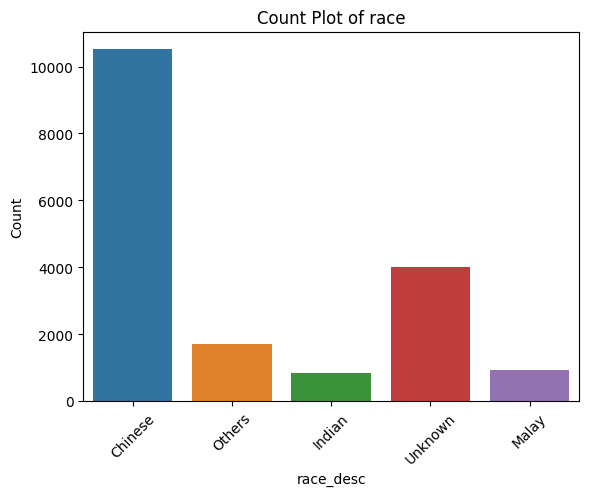

In [20]:
#CATEGORICAL
import seaborn as sns
sns.countplot(x='race_desc', data=df)
plt.xlabel('race_desc')
plt.ylabel('Count')
plt.title('Count Plot of race')
plt.xticks(rotation=45)
plt.show()

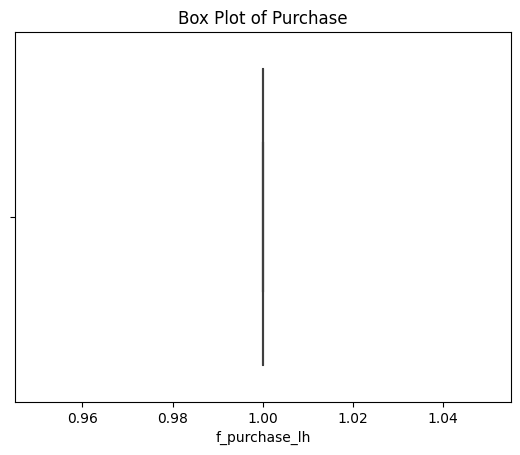

In [21]:
# Calculate correlations between numerical variables
correlation_matrix = df.corr()

# Create a scatter plot for two numerical variables
plt.scatter(df['numerical_column1'], df['numerical_column2'])
plt.xlabel('Numerical Column 1')
plt.ylabel('Numerical Column 2')
plt.title('Scatter Plot of Numerical Columns 1 and 2')
plt.show()

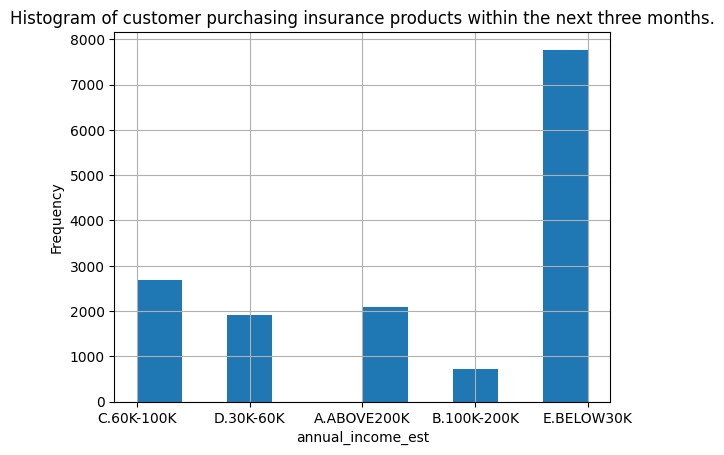

In [28]:
import matplotlib.pyplot as plt
df['annual_income_est'].hist()
plt.xlabel('annual_income_est')
plt.ylabel('Frequency')
plt.title('Histogram of customer purchasing insurance products within the next three months.')
plt.show()

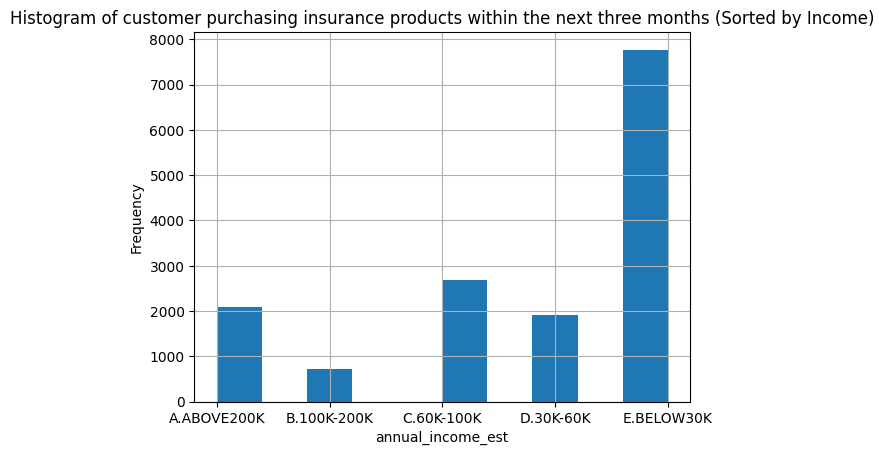

In [29]:
import matplotlib.pyplot as plt

# Sort the DataFrame by 'annual_income_est' in ascending order
df_sorted = df.sort_values(by='annual_income_est')
# Plot the histogram of the sorted 'annual_income_est' column
df_sorted['annual_income_est'].hist()
plt.xlabel('annual_income_est')
plt.ylabel('Frequency')
plt.title('Histogram of customer purchasing insurance products within the next three months (Sorted by Income)')
plt.show()

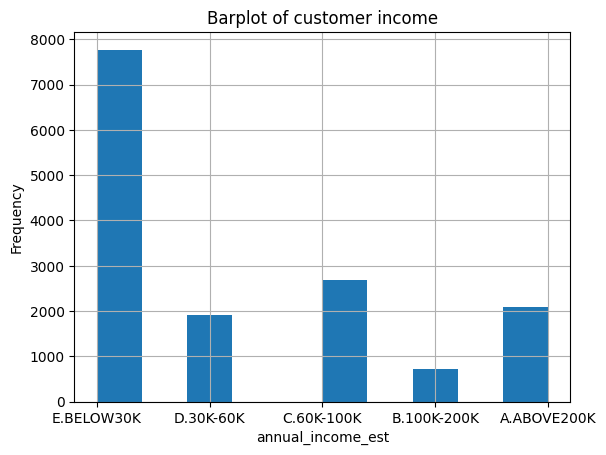

In [32]:
import matplotlib.pyplot as plt

# Sort the DataFrame by 'annual_income_est' in ascending order
df_sorted = df.sort_values(by='annual_income_est', ascending = False)
# Plot the histogram of the sorted 'annual_income_est' column
df_sorted['annual_income_est'].hist()
plt.xlabel('annual_income_est')
plt.ylabel('Frequency')
plt.title('Barplot of customer income')
plt.show()

In [36]:
#NUMERICAL VARIABLES
#POLICIES IN-FORCE 
# Assuming 'df' is your DataFrame and 'numerical_column' is the numerical variable you want to count
count = len(df['tot_inforce_pols'])
print(f"Number of total policies in-force: {count}")

#POLICIES CANCELLED
count2 = len(df['tot_cancel_pols'])
print(f"Number of total policies cancelled: {count2}")

count3 = len(df['f_ever_declined_la'])
print(f"Number of total policies declined: {count3}")


Number of total policies in-force: 17992
Number of total policies cancelled: 17992
Number of total policies declined: 17992


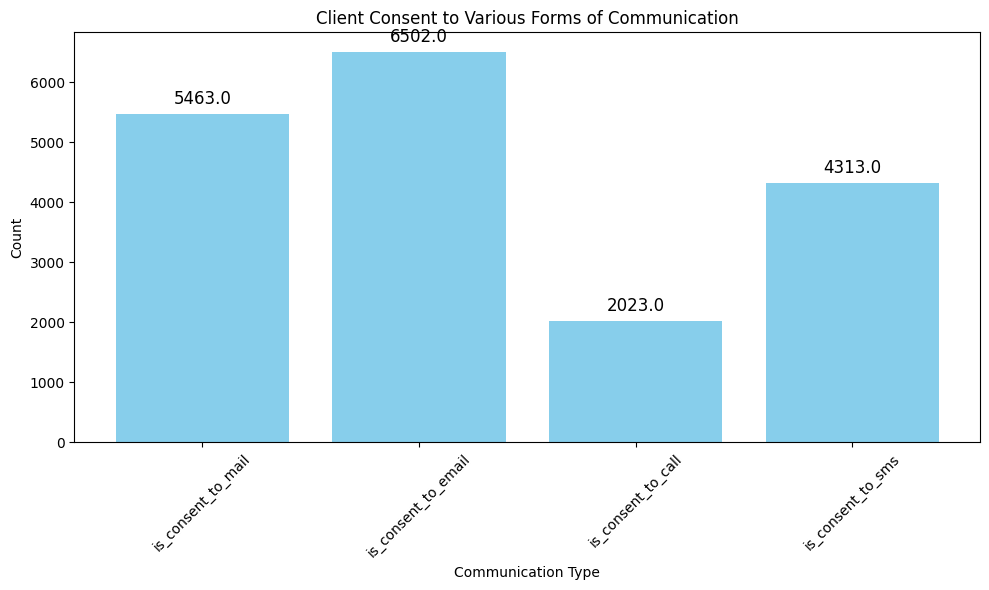

In [37]:
#LETS COMPARE WHICH MODE OF COMMUNICATION IS THE BEST
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'df' is your DataFrame

# Create a subset of the DataFrame with the consent flags
consent_flags = df[['is_consent_to_mail', 'is_consent_to_email', 'is_consent_to_call', 'is_consent_to_sms']]

# Calculate the counts of each consent type
counts = consent_flags.sum()

# Get the communication types as labels
communication_types = counts.index

# Get the counts as values
counts_values = counts.values

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(communication_types, counts_values, color='skyblue')
plt.xlabel('Communication Type')
plt.ylabel('Count')
plt.title('Client Consent to Various Forms of Communication')
plt.xticks(rotation=45)

# Display the count values above the bars
for i, count in enumerate(counts_values):
    plt.text(i, count + 100, str(count), ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

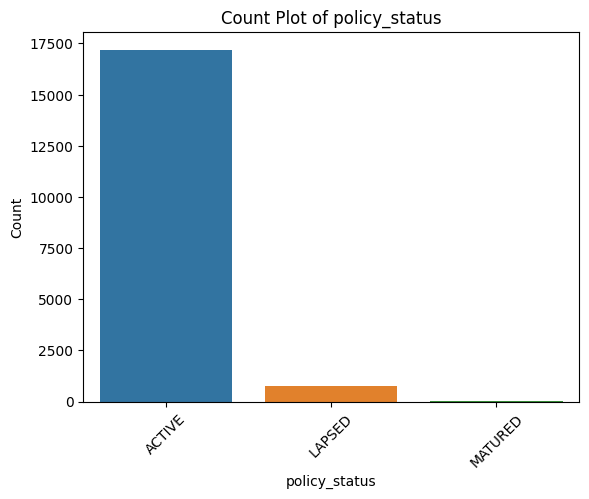

In [40]:
import seaborn as sns
sns.countplot(x='stat_flag', data=df)
plt.xlabel('policy_status')
plt.ylabel('Count')
plt.title('Count Plot of policy_status')
plt.xticks(rotation=45)
plt.show()


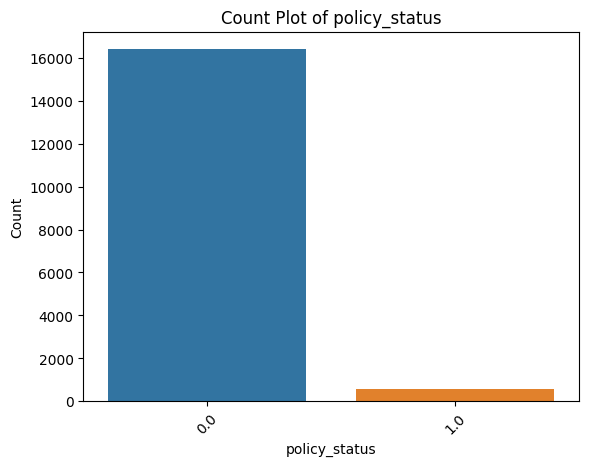

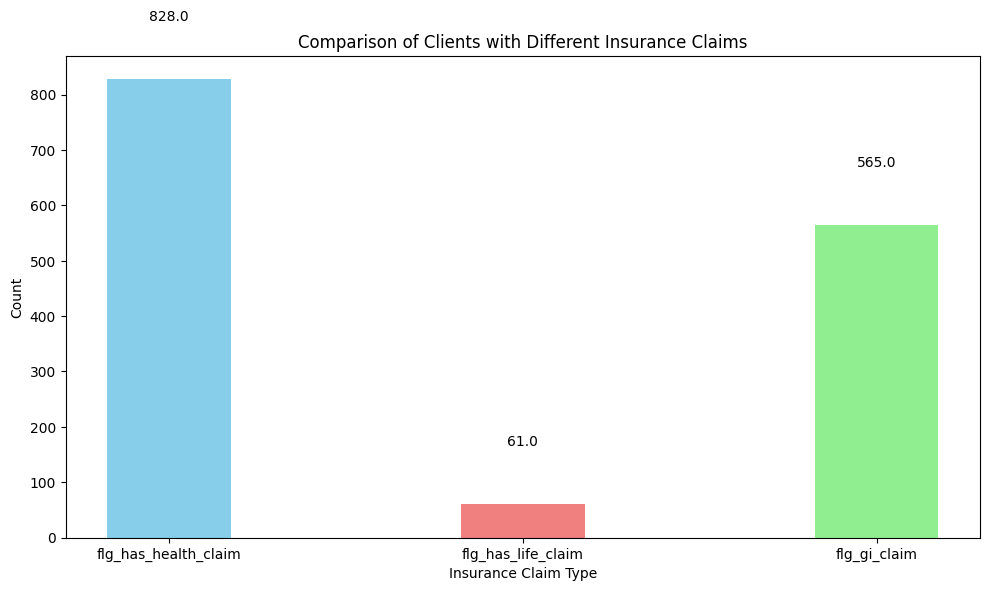

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'df' is your DataFrame

# Create a subset of the DataFrame with the insurance claims flags
claims_flags = df[['flg_has_health_claim', 'flg_has_life_claim', 'flg_gi_claim']]

# Calculate the counts of each type of insurance claim
claims_counts = claims_flags.sum()

# Get the insurance claim types as labels
claim_types = claims_counts.index

# Get the counts as values
claims_counts_values = claims_counts.values

# Create bar positions for the bars
x = np.arange(len(claim_types))

# Set the width of the bars
width = 0.35

# Create a grouped bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(x, claims_counts_values, width, color=['skyblue', 'lightcoral', 'lightgreen'])
plt.xlabel('Insurance Claim Type')
plt.ylabel('Count')
plt.title('Comparison of Clients with Different Insurance Claims')
plt.xticks(x, claim_types, rotation=0)

# Display the count values above the bars
for i, count in enumerate(claims_counts_values):
    plt.text(i, count + 100, str(count), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [73]:
from sklearn.model_selection import train_test_split
X = df[['is_consent_to_email','stat_flag','flg_has_health_claim']]
y = df[['f_purchase_lh']]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)
X

,is_consent_to_email,stat_flag,flg_has_health_claim
19550,0.0,ACTIVE,0.0
4600,0.0,ACTIVE,0.0
13337,1.0,ACTIVE,0.0
15074,0.0,ACTIVE,0.0
19724,1.0,ACTIVE,0.0
...,...,...,...
11284,0.0,LAPSED,0.0
11964,0.0,ACTIVE,0.0
5390,1.0,ACTIVE,0.0
860,1.0,ACTIVE,0.0


In [93]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load your dataframe
# df = ...

# Check data types
print("Data types before conversion:\n", df.dtypes)

# Convert categorical variables to numeric
# Adjust these steps based on your specific dataset
label_encoders = {}
for column in ['is_consent_to_email', 'stat_flag', 'flg_has_health_claim']:
    if df[column].dtype == 'object':
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
        label_encoders[column] = le

# Check data types after conversion
print("\nData types after conversion:\n", df.dtypes)

# Define X and y
X = df[['is_consent_to_email','stat_flag', 'flg_has_health_claim']]
y = df[['f_purchase_lh']]

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

# Now X should be ready for use in machine learning models


Data types before conversion:
 clntnum                       object
race_desc                     object
ctrycode_desc                 object
clttype                       object
stat_flag                      int64
                              ...   
giclaim_cnt_success           object
recency_giclaim_success       object
giclaim_cnt_unsuccess         object
recency_giclaim_unsuccess     object
f_purchase_lh                float64
Length: 300, dtype: object

Data types after conversion:
 clntnum                       object
race_desc                     object
ctrycode_desc                 object
clttype                       object
stat_flag                      int64
                              ...   
giclaim_cnt_success           object
recency_giclaim_success       object
giclaim_cnt_unsuccess         object
recency_giclaim_unsuccess     object
f_purchase_lh                float64
Length: 300, dtype: object
